# Deep-nilmtk Results exploration

The current notebook illustrates an example of appliances 

In [47]:
import pickle
import seaborn as sns

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 


from nilmtk.losses import rmse, f1_score

sns.set_style("whitegrid")


from scipy.interpolate import UnivariateSpline, make_interp_spline as mis , splrep, interp1d, splev, pchip
plt.rcParams["figure.figsize"] = (20,5)

In [48]:
PATH = '../../new_dnilm/'
FILENAME = 'baselines_anp_rnn_2.p'

## Checking the results of the experiments from MLFLOW

C:\Users\Hafsa\AppData\Local\Temp\ipykernel_22284\3159534760.py:4: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


The correlation for the kettle is 0.8285986845478079 p-value 5.185916604711689e-08
The correlation for the microwave is 0.803675482364778 p-value 8.90511821173768e-08
The correlation for the television is -0.41518937415402335 p-value 0.022516123494171515


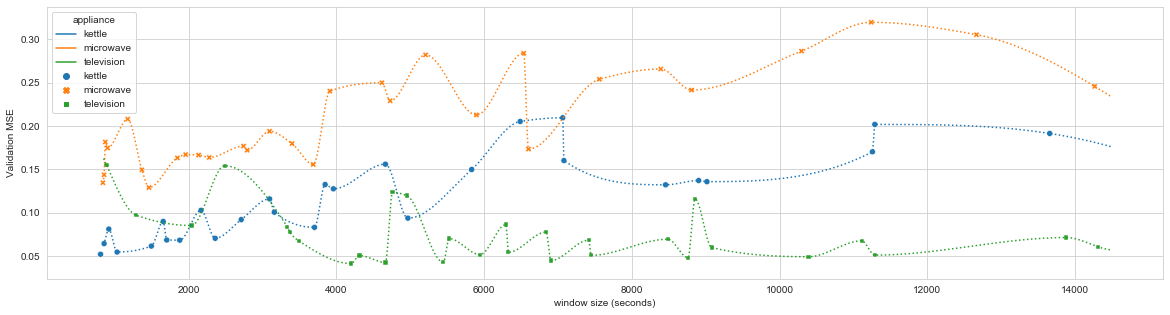

In [49]:
df = []
df2=[]

from scipy.stats.stats import pearsonr


def interpolate(x, y, x_new):
    pch = pchip(x, y)
    return pch(x_new)
  
corrs ={}
ps ={}

for app in ['kettle', 'microwave', 'television' ]:
    app_data = pd.read_csv(f"{PATH}{app}.csv")
    app_data = app_data.sort_values(['in_size'])
    app_data = app_data.drop_duplicates(subset=['in_size'])
    
    x, y = app_data['in_size'].values * 8 , app_data['val_loss'].values
   
    x_new = np.linspace(850, 14500, 5000)
    
    df.append(pd.DataFrame({
        'window size (seconds)': x_new,
        'Validation MSE':interpolate(x,y, x_new),
    }))
    df[-1]['appliance'] = app
    
    df2.append(pd.DataFrame({
        'window size (seconds)': app_data['in_size'].values * 8,
        'Validation MSE': app_data['val_loss'].values,
    }))
    corr, p = pearsonr(app_data["in_size"].values * 8, app_data["val_loss"].values)
    print(f'The correlation for the {app} is {corr} p-value {p}')
    df2[-1]['appliance'] = app
    corrs.update({app:corr})
    ps.update({app:p})

df = pd.concat(df, axis=0)
df = df.sort_values(['window size (seconds)'])
ax= sns.lineplot(data = df.reset_index(), x='window size (seconds)', y='Validation MSE', hue='appliance',    linestyle="dotted", color={'micorwave':'black', 'television':'red'})
ax.get_legend().remove()

df2 = pd.concat(df2, axis=0)
df2 = df2.sort_values(['appliance'])
sns.scatterplot(data = df2.reset_index(), x='window size (seconds)', y='Validation MSE', hue='appliance', style='appliance')
plt.savefig('params_optim.pdf')

Th previous plots shows the impact of the sequence length on the best training validation that can be aschieved. As the figure illustrates, the sequence length has an important impact on the training process and the performance that can be aschived. For both the kettle and the microwave, the validation MSE is higher with long window sizes. On the other hand, the television have smaller recorded samller values of validation loss with longer sequences. These findings are further confirmed using the pearson correlation. Regarding this measure, the kettle and microwave  have a strong positive correlation between the input window size and the validation MSE with a p-value in the order of 10e-8. In the case of television, a negative correlation is recorded with a 0.02 p-value. 

These observation can be justified with the fact that the duration of use of the kettle and the microwave is in the order of few minutes while it can go for several hours in the case of the television. Therefore, smaller window size would allow the deep model in the case of the first appliance to learn more features. 

In [50]:
apps = [ 'kettle', 'microwave', 'television' ]
pd.DataFrame({
'appliance': apps,
'worst MSE': [df2.loc[df2['appliance']==app].iloc[df2.loc[df2['appliance']==app]['Validation MSE'].values.argmax()]['Validation MSE'] for app in apps],
'window_max': [df2.loc[df2['appliance']==app].iloc[df2.loc[df2['appliance']==app]['Validation MSE'].values.argmax()]['window size (seconds)'] for app in apps],
'best MSE':  [df2.loc[df2['appliance']==app].iloc[df2.loc[df2['appliance']==app]['Validation MSE'].values.argmin()]['Validation MSE'] for app in apps],
'window_min': [df2.loc[df2['appliance']==app].iloc[df2.loc[df2['appliance']==app]['Validation MSE'].values.argmin()]['window size (seconds)'] for app in apps],
}).set_index('appliance').T



appliance,kettle,microwave,television
worst MSE,0.209449,0.319571,0.155262
window_max,7064.000000,11240.000000,888.000000
best MSE,0.052027,0.128902,0.041312
window_min,808.000000,1464.000000,4200.000000


## Reading the results of the experiment

In [51]:
with open(PATH+FILENAME, 'rb') as f:
    results = pickle.load(f)

results.keys()

dict_keys(['error_keys', 'errors', 'train_mains', 'train_submeters', 'test_mains', 'test_submeters', 'gt', 'predictions', 'execution_time'])

## Plotting the results of the best window length

In [52]:
gt = pd.DataFrame({
    key: data[0].values.reshape(-1) for (key, data) in results['test_submeters']
}, index = results['test_mains'][0].index )

predictions = results['predictions']['Seq2Pointbaseline']
predictions[predictions<0]=0

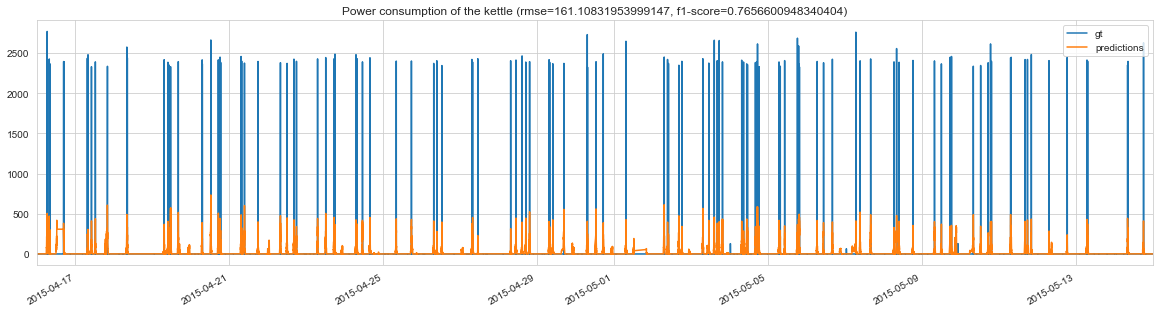

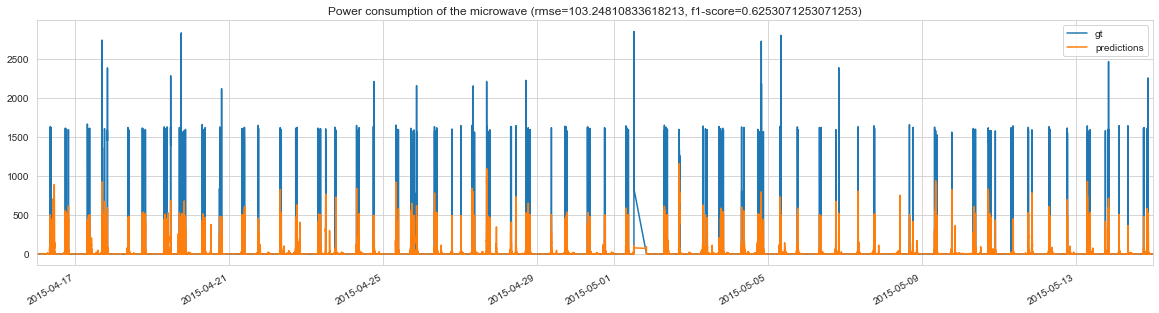

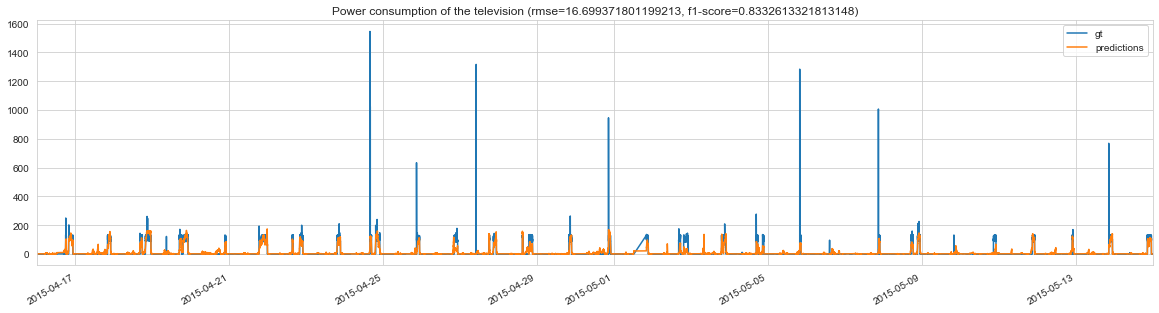

In [53]:
for col in predictions.columns:
    gt[col].plot(figsize=(20,5), label='gt')
    predictions[col].plot(figsize=(20,5), label='predictions')
    plt.legend(loc='upper right')
    plt.title(f"Power consumption of the {col} (rmse={rmse(gt[col].values, predictions[col].values)}, f1-score={f1_score(gt[col].values>threshold[col], predictions[col].values>threshold[col])})" )
    plt.show()

As the previous plots show, the seq2point implemented in the toolkit performs good when detecting  the events. Nonethelss, teh predicted signal is atenuated. The model tends to underestimate the value of power generated. This could be due to many factors including the length of the network. In this case, residual connections may be good option ot overcome this problem. It is also worth mentionning that this observation is happends to be a problem only for big consuming appliances (kettle and the microwave) and not small consuming appliances(television).

## Final results

In this final section, we will explore the effect of the threshold to evaluate the ability if the model to detect soperational states properly. Visually, the seq2point seem to perform well on event detection and underestimating the power consumption values. Howevre, the f1-score obtained is contradictory and shows that the model is poor. 

It is worth mentionning that the default threhsold used for all applainces in nilmtk is 10 watts. This is not realistic since some appliances consume more than other and this would have an important impact on performance. Let's explore this aspect and see if this hypothysis is valid or not. 

In [83]:
from sklearn.metrics import f1_score as f1

f1_score = []

for col in predictions.columns:
    gt_col = gt[col].values
    pred = predictions[col].values
    f1_score_col =[{
            'appliance':col,
            'threshold': i,
            'f1-score': f1(
                1 * (gt_col>i),
                1 * (pred>i)
            )
        } for i in range(0, 1000,2)]
    f1_score += f1_score_col

In [79]:
res = pd.DataFrame(f1_score)

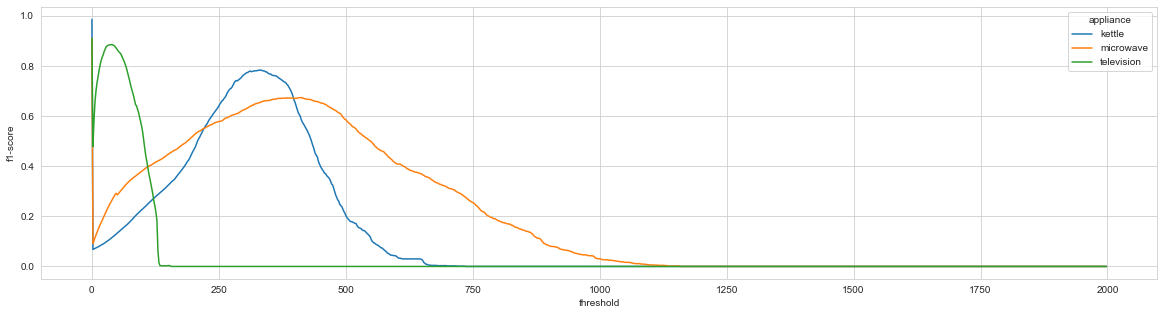

In [80]:
sns.lineplot(data=res, x='threshold', y='f1-score', hue='appliance')

As it can be seen in the previous plot, the f1-score calculated when the model is a regression model is highly dependent on the ON threshold that is specific to each appliance. Therefore, this metric as calculated by the NILMtk could be unreliable as a standard threshold of 10 watts is used to determine the ON/OFF states of all appliances.

In [81]:
threshold ={
'kettle':300,
'microwave':300,
'television':50
}

In [84]:
from nilmtk.losses import mae, rmse
results = []
for col in predictions.columns:
    gt_col = gt[col].values
    pred = predictions[col].values
    results.append({
        'appliance':col,
        'coorelation':corrs[col],
        'p-value':ps[col],
        'MAE':mae(gt_col, pred),
        'RMSE':rmse(gt_col, pred),
        'f1-score':f1((gt_col> threshold[col]), (pred> threshold[col]))
    })

pd.DataFrame(results)

,appliance,coorelation,p-value,MAE,RMSE,f1-score
0,kettle,0.828599,5.185917e-08,24.873255,161.108320,0.765660
1,microwave,0.803675,8.905118e-08,17.693117,103.248108,0.625307
2,television,-0.415189,2.251612e-02,5.725037,16.699372,0.864663
